# Paths

In [1]:
dataset_path = "./datasets/ASDID"
tensorboard_path = "logs/"
models_path = "./models/ASDID/"

# Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [5]:
from torchvision.models import resnet50, ResNet50_Weights
my_transform = ResNet50_Weights.IMAGENET1K_V1.transforms()

In [6]:
import torch
import torchvision

data = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)

train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 512

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(len(data))
print(len(train_data))
print(len(test_data))

10035
7024
3011


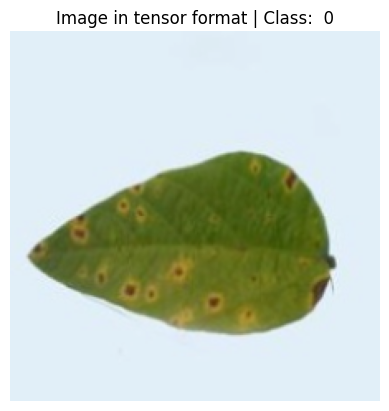

In [6]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

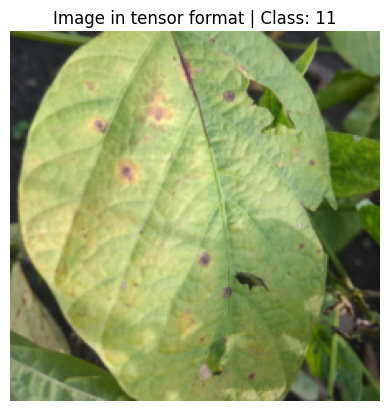

In [7]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

# Training

In [8]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    #optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for inputs, labels in train_loader:
        print("Labels:", labels.unique())
        break


    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        path = f'{models_path}ResNet50-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

# Validation

In [9]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Run

In [10]:
import torch
from torchvision.models import resnet50

# arquivo com modelo treinado no dataset SoyNet
path = './models/SoyNet/ResNet50-SoyNet-96.53.pkl'

# carrega o modelo
modelResNetTL = torch.load(path, weights_only=False)

# verifica as camadas
for name, param in modelResNetTL.named_parameters():
    print(f"{name}")


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [12]:
for param in modelResNetTL.parameters():
    param.requires_grad = False

modelResNetTL.fc.requires_grad_(True)
# num_classes = 10
num_classes = 13
modelResNetTL.fc = torch.nn.Linear(modelResNetTL.fc.in_features, num_classes)

In [13]:
# Check which layers are frozen
for name, param in modelResNetTL.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.0.conv3.weight: Frozen
layer1.0.bn3.weight: Frozen
layer1.0.bn3.bias: Frozen
layer1.0.downsample.0.weight: Frozen
layer1.0.downsample.1.weight: Frozen
layer1.0.downsample.1.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer1.1.conv3.weight: Frozen
layer1.1.bn3.weight: Frozen
layer1.1.bn3.bias: Frozen
layer1.2.conv1.weight: Frozen
layer1.2.bn1.weight: Frozen
layer1.2.bn1.bias: Frozen
layer1.2.conv2.weight: Frozen
layer1.2.bn2.weight: Frozen
layer1.2.bn2.bias: Frozen
layer1.2.conv3.weight: Frozen
layer1.2.bn3.weight: Frozen
layer1.2.bn3.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: F

In [15]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = modelResNetTL.to(my_device)

epochs = 100
lr = 1e-4
dataset = 'SoyBean'
prefix = 'ResNet50-Adam-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Running on cuda
Labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])


Training epochs...:   1%|          | 1/100 [01:40<2:46:22, 100.84s/it]

Saving Best Model with Accuracy:  10.826210826210826
Epoch:   1 | Accuracy : 10.8262%


Training epochs...:   2%|▏         | 2/100 [03:17<2:40:42, 98.39s/it] 

Saving Best Model with Accuracy:  12.820512820512821
Epoch:   2 | Accuracy : 12.8205%


Training epochs...:   3%|▎         | 3/100 [04:41<2:28:41, 91.97s/it]

Saving Best Model with Accuracy:  15.384615384615385
Epoch:   3 | Accuracy : 15.3846%


Training epochs...:   4%|▍         | 4/100 [06:07<2:23:06, 89.45s/it]

Saving Best Model with Accuracy:  19.373219373219374
Epoch:   4 | Accuracy : 19.3732%


Training epochs...:   5%|▌         | 5/100 [07:34<2:20:15, 88.58s/it]

Saving Best Model with Accuracy:  22.79202279202279
Epoch:   5 | Accuracy : 22.7920%


Training epochs...:   6%|▌         | 6/100 [09:03<2:18:55, 88.67s/it]

Saving Best Model with Accuracy:  27.35042735042735
Epoch:   6 | Accuracy : 27.3504%


Training epochs...:   7%|▋         | 7/100 [10:31<2:17:25, 88.67s/it]

Saving Best Model with Accuracy:  31.054131054131055
Epoch:   7 | Accuracy : 31.0541%


Training epochs...:   8%|▊         | 8/100 [12:02<2:16:43, 89.17s/it]

Saving Best Model with Accuracy:  37.60683760683761
Epoch:   8 | Accuracy : 37.6068%


Training epochs...:   9%|▉         | 9/100 [13:32<2:15:43, 89.49s/it]

Saving Best Model with Accuracy:  41.31054131054131
Epoch:   9 | Accuracy : 41.3105%


Training epochs...:  10%|█         | 10/100 [15:02<2:14:23, 89.59s/it]

Saving Best Model with Accuracy:  47.00854700854701
Epoch:  10 | Accuracy : 47.0085%


Training epochs...:  11%|█         | 11/100 [16:33<2:13:27, 89.97s/it]

Saving Best Model with Accuracy:  50.712250712250714
Epoch:  11 | Accuracy : 50.7123%


Training epochs...:  12%|█▏        | 12/100 [18:04<2:12:23, 90.27s/it]

Saving Best Model with Accuracy:  54.13105413105413
Epoch:  12 | Accuracy : 54.1311%


Training epochs...:  13%|█▎        | 13/100 [19:35<2:11:29, 90.68s/it]

Saving Best Model with Accuracy:  56.6951566951567
Epoch:  13 | Accuracy : 56.6952%


Training epochs...:  14%|█▍        | 14/100 [21:06<2:10:13, 90.85s/it]

Saving Best Model with Accuracy:  58.68945868945869
Epoch:  14 | Accuracy : 58.6895%


Training epochs...:  15%|█▌        | 15/100 [22:38<2:08:59, 91.05s/it]

Saving Best Model with Accuracy:  60.11396011396011
Epoch:  15 | Accuracy : 60.1140%


Training epochs...:  16%|█▌        | 16/100 [24:11<2:08:13, 91.58s/it]

Saving Best Model with Accuracy:  61.82336182336182
Epoch:  16 | Accuracy : 61.8234%


Training epochs...:  17%|█▋        | 17/100 [25:42<2:06:21, 91.35s/it]

Saving Best Model with Accuracy:  62.96296296296296
Epoch:  17 | Accuracy : 62.9630%


Training epochs...:  18%|█▊        | 18/100 [27:13<2:04:48, 91.32s/it]

Saving Best Model with Accuracy:  64.1025641025641
Epoch:  18 | Accuracy : 64.1026%


Training epochs...:  19%|█▉        | 19/100 [28:45<2:03:38, 91.58s/it]

Epoch:  19 | Accuracy : 64.1026%


Training epochs...:  20%|██        | 20/100 [30:16<2:02:04, 91.55s/it]

Saving Best Model with Accuracy:  65.8119658119658
Epoch:  20 | Accuracy : 65.8120%


Training epochs...:  21%|██        | 21/100 [31:48<2:00:21, 91.41s/it]

Epoch:  21 | Accuracy : 65.5271%


Training epochs...:  22%|██▏       | 22/100 [33:19<1:58:53, 91.45s/it]

Epoch:  22 | Accuracy : 65.5271%


Training epochs...:  23%|██▎       | 23/100 [34:51<1:57:38, 91.66s/it]

Epoch:  23 | Accuracy : 65.8120%


Training epochs...:  24%|██▍       | 24/100 [36:23<1:55:57, 91.54s/it]

Saving Best Model with Accuracy:  67.23646723646723
Epoch:  24 | Accuracy : 67.2365%


Training epochs...:  25%|██▌       | 25/100 [37:53<1:54:00, 91.20s/it]

Saving Best Model with Accuracy:  68.37606837606837
Epoch:  25 | Accuracy : 68.3761%


Training epochs...:  26%|██▌       | 26/100 [39:25<1:52:43, 91.39s/it]

Epoch:  26 | Accuracy : 68.0912%


Training epochs...:  27%|██▋       | 27/100 [40:56<1:51:13, 91.41s/it]

Saving Best Model with Accuracy:  69.23076923076923
Epoch:  27 | Accuracy : 69.2308%


Training epochs...:  28%|██▊       | 28/100 [42:28<1:49:47, 91.50s/it]

Saving Best Model with Accuracy:  70.37037037037037
Epoch:  28 | Accuracy : 70.3704%


Training epochs...:  29%|██▉       | 29/100 [44:00<1:48:30, 91.69s/it]

Saving Best Model with Accuracy:  70.94017094017094
Epoch:  29 | Accuracy : 70.9402%


Training epochs...:  30%|███       | 30/100 [45:33<1:47:20, 92.01s/it]

Saving Best Model with Accuracy:  71.7948717948718
Epoch:  30 | Accuracy : 71.7949%


Training epochs...:  31%|███       | 31/100 [47:05<1:46:00, 92.18s/it]

Saving Best Model with Accuracy:  72.36467236467236
Epoch:  31 | Accuracy : 72.3647%


Training epochs...:  32%|███▏      | 32/100 [48:37<1:44:21, 92.08s/it]

Saving Best Model with Accuracy:  72.93447293447294
Epoch:  32 | Accuracy : 72.9345%


Training epochs...:  33%|███▎      | 33/100 [50:11<1:43:17, 92.50s/it]

Saving Best Model with Accuracy:  74.07407407407408
Epoch:  33 | Accuracy : 74.0741%


Training epochs...:  34%|███▍      | 34/100 [51:42<1:41:26, 92.23s/it]

Epoch:  34 | Accuracy : 74.0741%


Training epochs...:  35%|███▌      | 35/100 [53:36<1:46:50, 98.63s/it]

Epoch:  35 | Accuracy : 74.0741%


Training epochs...:  36%|███▌      | 36/100 [55:45<1:54:56, 107.76s/it]

Saving Best Model with Accuracy:  74.35897435897436
Epoch:  36 | Accuracy : 74.3590%


Training epochs...:  37%|███▋      | 37/100 [57:16<1:47:58, 102.83s/it]

Epoch:  37 | Accuracy : 74.3590%


Training epochs...:  38%|███▊      | 38/100 [58:46<1:42:08, 98.84s/it] 

Saving Best Model with Accuracy:  75.78347578347578
Epoch:  38 | Accuracy : 75.7835%


Training epochs...:  39%|███▉      | 39/100 [1:00:15<1:37:38, 96.04s/it]

Epoch:  39 | Accuracy : 75.4986%


Training epochs...:  40%|████      | 40/100 [1:01:45<1:34:01, 94.02s/it]

Saving Best Model with Accuracy:  76.06837606837607
Epoch:  40 | Accuracy : 76.0684%


Training epochs...:  41%|████      | 41/100 [1:03:15<1:31:19, 92.87s/it]

Epoch:  41 | Accuracy : 76.0684%


Training epochs...:  42%|████▏     | 42/100 [1:04:44<1:28:34, 91.63s/it]

Saving Best Model with Accuracy:  76.63817663817663
Epoch:  42 | Accuracy : 76.6382%


Training epochs...:  43%|████▎     | 43/100 [1:06:12<1:26:03, 90.59s/it]

Epoch:  43 | Accuracy : 75.7835%


Training epochs...:  44%|████▍     | 44/100 [1:07:40<1:23:47, 89.78s/it]

Epoch:  44 | Accuracy : 75.4986%


Training epochs...:  45%|████▌     | 45/100 [1:09:09<1:22:10, 89.65s/it]

Epoch:  45 | Accuracy : 75.7835%


Training epochs...:  46%|████▌     | 46/100 [1:10:37<1:20:15, 89.17s/it]

Epoch:  46 | Accuracy : 75.7835%


Training epochs...:  47%|████▋     | 47/100 [1:12:05<1:18:30, 88.88s/it]

Epoch:  47 | Accuracy : 76.6382%


Training epochs...:  48%|████▊     | 48/100 [1:13:35<1:17:12, 89.08s/it]

Saving Best Model with Accuracy:  76.92307692307692
Epoch:  48 | Accuracy : 76.9231%


Training epochs...:  49%|████▉     | 49/100 [1:15:05<1:15:57, 89.35s/it]

Saving Best Model with Accuracy:  77.20797720797721
Epoch:  49 | Accuracy : 77.2080%


Training epochs...:  50%|█████     | 50/100 [1:16:35<1:14:44, 89.70s/it]

Epoch:  50 | Accuracy : 77.2080%


Training epochs...:  51%|█████     | 51/100 [1:18:07<1:13:47, 90.35s/it]

Epoch:  51 | Accuracy : 77.2080%


Training epochs...:  52%|█████▏    | 52/100 [1:19:39<1:12:42, 90.89s/it]

Epoch:  52 | Accuracy : 77.2080%


Training epochs...:  53%|█████▎    | 53/100 [1:21:10<1:11:16, 91.00s/it]

Epoch:  53 | Accuracy : 77.2080%


Training epochs...:  54%|█████▍    | 54/100 [1:22:42<1:09:57, 91.25s/it]

Epoch:  54 | Accuracy : 77.2080%


Training epochs...:  55%|█████▌    | 55/100 [1:24:13<1:08:22, 91.18s/it]

Saving Best Model with Accuracy:  78.06267806267806
Epoch:  55 | Accuracy : 78.0627%


Training epochs...:  56%|█████▌    | 56/100 [1:25:44<1:06:49, 91.12s/it]

Saving Best Model with Accuracy:  78.34757834757835
Epoch:  56 | Accuracy : 78.3476%


Training epochs...:  57%|█████▋    | 57/100 [1:27:14<1:04:56, 90.62s/it]

Epoch:  57 | Accuracy : 78.0627%


Training epochs...:  58%|█████▊    | 58/100 [1:28:43<1:03:13, 90.33s/it]

Epoch:  58 | Accuracy : 78.0627%


Training epochs...:  59%|█████▉    | 59/100 [1:30:13<1:01:37, 90.17s/it]

Epoch:  59 | Accuracy : 78.0627%


Training epochs...:  60%|██████    | 60/100 [1:31:44<1:00:09, 90.23s/it]

Epoch:  60 | Accuracy : 78.0627%


Training epochs...:  61%|██████    | 61/100 [1:33:14<58:37, 90.19s/it]  

Saving Best Model with Accuracy:  78.63247863247864
Epoch:  61 | Accuracy : 78.6325%


Training epochs...:  62%|██████▏   | 62/100 [1:34:44<57:06, 90.16s/it]

Saving Best Model with Accuracy:  79.2022792022792
Epoch:  62 | Accuracy : 79.2023%


Training epochs...:  63%|██████▎   | 63/100 [1:36:14<55:35, 90.14s/it]

Epoch:  63 | Accuracy : 78.6325%


Training epochs...:  64%|██████▍   | 64/100 [1:37:43<53:55, 89.87s/it]

Epoch:  64 | Accuracy : 78.9174%


Training epochs...:  65%|██████▌   | 65/100 [1:39:11<52:09, 89.40s/it]

Saving Best Model with Accuracy:  79.77207977207978
Epoch:  65 | Accuracy : 79.7721%


Training epochs...:  66%|██████▌   | 66/100 [1:40:41<50:38, 89.38s/it]

Epoch:  66 | Accuracy : 78.9174%


Training epochs...:  67%|██████▋   | 67/100 [1:42:09<49:02, 89.17s/it]

Epoch:  67 | Accuracy : 77.7778%


Training epochs...:  68%|██████▊   | 68/100 [1:43:40<47:50, 89.69s/it]

Epoch:  68 | Accuracy : 78.0627%


Training epochs...:  69%|██████▉   | 69/100 [1:45:11<46:31, 90.05s/it]

Epoch:  69 | Accuracy : 78.6325%


Training epochs...:  70%|███████   | 70/100 [1:46:43<45:16, 90.57s/it]

Epoch:  70 | Accuracy : 78.6325%


Training epochs...:  71%|███████   | 71/100 [1:48:14<43:50, 90.72s/it]

Epoch:  71 | Accuracy : 78.3476%


Training epochs...:  72%|███████▏  | 72/100 [1:49:45<42:17, 90.64s/it]

Epoch:  72 | Accuracy : 78.6325%


Training epochs...:  73%|███████▎  | 73/100 [1:51:16<40:50, 90.76s/it]

Epoch:  73 | Accuracy : 78.9174%


Training epochs...:  74%|███████▍  | 74/100 [1:52:45<39:10, 90.39s/it]

Epoch:  74 | Accuracy : 78.9174%


Training epochs...:  75%|███████▌  | 75/100 [1:54:14<37:25, 89.81s/it]

Epoch:  75 | Accuracy : 78.9174%


Training epochs...:  76%|███████▌  | 76/100 [1:55:42<35:43, 89.31s/it]

Epoch:  76 | Accuracy : 79.2023%


Training epochs...:  77%|███████▋  | 77/100 [1:57:11<34:14, 89.31s/it]

Epoch:  77 | Accuracy : 79.4872%


Training epochs...:  78%|███████▊  | 78/100 [1:58:40<32:44, 89.32s/it]

Epoch:  78 | Accuracy : 79.4872%


Training epochs...:  79%|███████▉  | 79/100 [2:00:10<31:16, 89.36s/it]

Epoch:  79 | Accuracy : 79.2023%


Training epochs...:  80%|████████  | 80/100 [2:01:40<29:52, 89.62s/it]

Epoch:  80 | Accuracy : 78.6325%


Training epochs...:  81%|████████  | 81/100 [2:03:09<28:17, 89.37s/it]

Epoch:  81 | Accuracy : 78.6325%


Training epochs...:  82%|████████▏ | 82/100 [2:04:37<26:43, 89.07s/it]

Epoch:  82 | Accuracy : 78.6325%


Training epochs...:  83%|████████▎ | 83/100 [2:06:06<25:12, 88.96s/it]

Epoch:  83 | Accuracy : 78.6325%


Training epochs...:  84%|████████▍ | 84/100 [2:07:34<23:38, 88.65s/it]

Epoch:  84 | Accuracy : 78.9174%


Training epochs...:  85%|████████▌ | 85/100 [2:09:02<22:08, 88.54s/it]

Epoch:  85 | Accuracy : 79.2023%


Training epochs...:  86%|████████▌ | 86/100 [2:10:30<20:37, 88.41s/it]

Saving Best Model with Accuracy:  80.34188034188034
Epoch:  86 | Accuracy : 80.3419%


Training epochs...:  87%|████████▋ | 87/100 [2:11:58<19:07, 88.27s/it]

Saving Best Model with Accuracy:  80.91168091168092
Epoch:  87 | Accuracy : 80.9117%


Training epochs...:  88%|████████▊ | 88/100 [2:13:28<17:45, 88.80s/it]

Epoch:  88 | Accuracy : 80.9117%


Training epochs...:  89%|████████▉ | 89/100 [2:14:57<16:16, 88.77s/it]

Epoch:  89 | Accuracy : 80.9117%


Training epochs...:  90%|█████████ | 90/100 [2:16:26<14:47, 88.74s/it]

Epoch:  90 | Accuracy : 80.6268%


Training epochs...:  91%|█████████ | 91/100 [2:17:54<13:18, 88.75s/it]

Epoch:  91 | Accuracy : 80.0570%


Training epochs...:  92%|█████████▏| 92/100 [2:19:23<11:48, 88.60s/it]

Epoch:  92 | Accuracy : 80.3419%


Training epochs...:  93%|█████████▎| 93/100 [2:20:50<10:18, 88.32s/it]

Epoch:  93 | Accuracy : 79.7721%


Training epochs...:  94%|█████████▍| 94/100 [2:22:18<08:49, 88.17s/it]

Epoch:  94 | Accuracy : 79.7721%


Training epochs...:  95%|█████████▌| 95/100 [2:23:47<07:21, 88.40s/it]

Epoch:  95 | Accuracy : 80.0570%


Training epochs...:  96%|█████████▌| 96/100 [2:25:16<05:54, 88.50s/it]

Epoch:  96 | Accuracy : 79.7721%


Training epochs...:  97%|█████████▋| 97/100 [2:26:45<04:25, 88.64s/it]

Epoch:  97 | Accuracy : 80.3419%


In [ ]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    # my_transform = AlexNet_Weights.IMAGENET1K_V1.transforms()
    # my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "BacterialBlight", "CercosporaLeafBlight", "DowneyMildew", "Frogeye", "Healthy", "PotassiumDeficiency",
        "SoybeanRust", "TargetSpot", "UnusedCercosporaLeafBlight", "UnusedHealthy", "UnusedSoybeanRust"
    ]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
